## Problema 1  Distribucion optima de recursos  

Santigo Casasbuenas - 202214932

Amalia Carbonell - 202122079 

**1. Preprocesamiento:**
- Cambiar toneladas por Kg para las unidades de peso de los recursos (1 Tonelada = 1000Kg)
- Dejamos uniandes de volumen en m^3


**2. Definicion de conjuntos y parametros:** 
Conjuntos: 

$R$ : es el conjunto de Recursos $R =  \{r1, r2,r3,r4,r5\}$

$A$ : es el conjunto de Aviones  $A =  \{a1, a2, a3\}$

- (j ∈ J)(j recorre alimentos )

- (i ∈ N)( i recorre nutrientes )

Parametros 

Para los recursos: 
- $V_{r}$ --> valor del recurso $r$ 
- $P_{r}$ --> Peso del recurso $r$
- $M_{r}$ --> Volumen del recurso $r$

Para los aviones: 
- $K_{a}$ --> Capacidad peso del avion $a$
- $L_{a}$ --> Capacidad Volumetrica del avion $a$

**3. Variable de decision** 
$X_{ra}$ : Cantidad del recurso $r$ que va en el avion $a$ 
 - Como los equipos medicos no se pueden fraccionar planteamos una restriccion 
$X_{ra} \geq 0$ Para todo r en R y todo a en A
$X_{ra} \forall Z \geq 0 | r$ = equipos medicos 

$Y_{ra}$ : Variable binaria que indica si el recurso $r$ va en el avion $a$ 
$$ 
  Y_{ra} =
  \begin{cases} 
  1 & \text{si el recurso } r \text{ si se encuentar en el avion }a \text{} \\ 
  0 & \text{si el recurso  } j \text{ no se encuentra en el avion }a \text{}
  \end{cases} 
  $$

**4. Funcion objetivo**
-   Maximizar el valor total de los recursos transportados. Es decir, asignar los recursos a los aviones de tal manera que cada avion lleve el mayor valor posible 
-   $$\max \left( \sum_{a \in A} \sum_{r \in R} V_r \cdot X_{r,a} \right)$$

### 5. Restricciones  

**1. Restricción de peso de un avión**  
La suma de los pesos $p_{r}$ de los recursos no debe exceder la capacidad de peso del avión $K_{a}$.  
Esto aplica para todos los aviones:  

$$
\sum_{r \in R} p_r \cdot X_{r,a} \leq k_a, \quad \forall a \in A
$$

**2. Restricción de volumen de un avión**
La suma de los volúmenes $m_{r}$ de los recursos no debe exceder la capacidad volumétrica del avión $L_{a}$.  
Esto aplica para todos los aviones:  

$$
\sum_{r \in R} m_r \cdot X_{r,a} \leq L_a, \quad \forall a \in A
$$

**3. Medicinas no pueden estar en el avión 1**
Pensamos en dos posibles soluciones usando las variables de decisión:  

Opción 1:  

$$ X_{r,a} = 0, \quad \forall r \in R, \quad r = \text{medicinas}, \quad \forall a \in A, \quad a = 1 $$

Opción 2:  

$$ Y_{r,a} = 0, \quad \forall r \in R, \quad r = \text{medicinas}, \quad \forall a \in A, \quad a = 1 $$

**4.  Restricción de compatibilidad**  
Los recursos "equipos médicos" y "agua potable" no pueden ir en el mismo avión. Aplica para todos los aviones:  

$$ Y_{e_m, a} + Y_{a_p, a} \leq 1, \quad \forall a \in A $$

**5. Restriccion capacidad**
Para todos los recursos, la sumatoria de lo que se envia debe ser menor o igual a la sumatoria del peso de los recursos 
$$ X_{r,a} \leq \sum_{r \in R} P_{r}, \quad \forall a \in A$$

Model unknown

  Variables:
    Voloc : Size=15, Index=Recursos*Aviones
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (1, 1) :     0 :   7.0 :  None : False : False : NonNegativeReals
        (1, 2) :     0 :   1.0 :  None : False : False : NonNegativeReals
        (1, 3) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (2, 1) :     0 :   2.0 :  None : False : False : NonNegativeReals
        (2, 2) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (2, 3) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (3, 1) :     0 :  10.0 :  None : False : False : NonNegativeReals
        (3, 2) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (3, 3) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (4, 1) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (4, 2) :     0 :  12.0 :  None : False : False : NonNegativeReals
        (4, 3) :     0 :   0.0 :  None : False : F

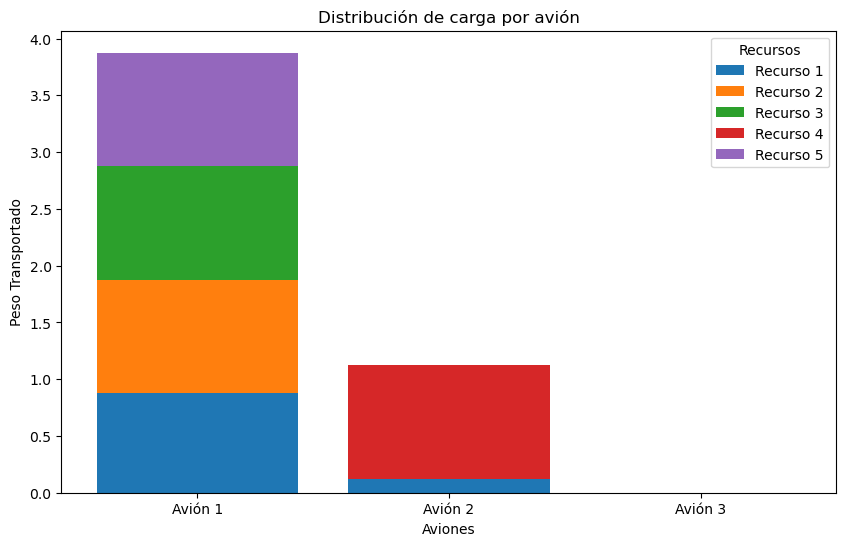

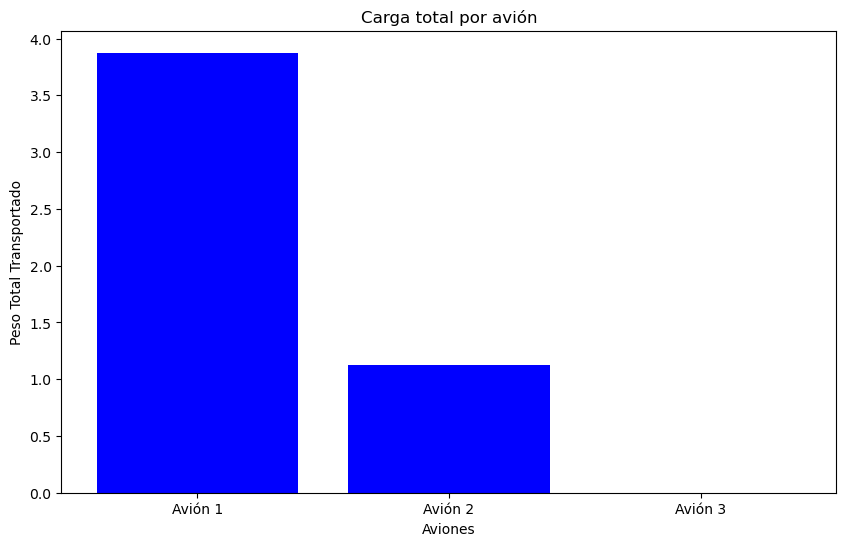

In [47]:
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt

# Crear el modelo de optimización
model = ConcreteModel()
# Conjuntos de recursos y aviones
model.Recursos = RangeSet(1,5)
model.Aviones = RangeSet(1,3)

# Datos de los recursos
resources_data = {
    1: {'nombre': 'AlimentosBasicos','value': 50, 'weight': 15000, 'volume': 8,  'fraccionable': True},
    2: {'nombre':'Medicinas',       'value': 100, 'weight': 5000,  'volume': 2,  'fraccionable': True},
    3: {'nombre':'EquiposMedicos',   'value': 120,'weight': 20000, 'volume': 10, 'fraccionable': False},
    4: {'nombre':'AguaPotable',      'value': 60, 'weight': 18000, 'volume': 12, 'fraccionable': True},
    5: {'nombre':'Mantas', 'value': 40, 'weight': 10000, 'volume': 6,  'fraccionable': True}
}

# Datos de los aviones
planes_data = {
    1: {'weight_capacity': 30000, 'volume_capacity': 25},
    2: {'weight_capacity': 40000, 'volume_capacity': 30},
    3: {'weight_capacity': 50000, 'volume_capacity': 35}
}


# Variables 
model.CapPeso = Param(model.Aviones, initialize={a: planes_data[a]['weight_capacity'] for a in planes_data})
model.CapVol = Param(model.Aviones, initialize={a: planes_data[a]['volume_capacity'] for a in planes_data})
model.Volumen = Param(model.Recursos, initialize={r: resources_data[r]['volume'] for r in resources_data})
model.PesoTot = Param(model.Recursos, initialize={r: resources_data[r]['weight'] for r in resources_data})
model.Valor = Param(model.Recursos, initialize={r: resources_data[r]['value'] for r in resources_data})

model.Voloc = Var(model.Recursos, model.Aviones, within=NonNegativeReals)
model.Cantidad = Var(model.Recursos, model.Aviones, within=NonNegativeReals)
model.x = Var(model.Recursos, domain=Binary)

#funcion Objetivo 
model.obj = Objective(expr=sum(model.Valor[r]*model.x[r] for r in model.Recursos), sense=maximize)


# Restricciones capacidad de peso en avión
def peso_por_avion_rule(model, a):
    return sum(model.Cantidad[r, a] for r in model.Recursos) <= model.CapPeso[a]
model.peso_por_avion = Constraint(model.Aviones, rule=peso_por_avion_rule)
model.volumen = ConstraintList()
for a in model.Aviones:
    for r, data in resources_data.items():
        model.volumen.add(expr=model.Voloc[r, a] == model.Cantidad[r, a] * data['volume'])
    model.volumen.add(sum(model.Voloc[r, a] for r in model.Recursos) <= model.CapVol[a])

# Exclusividad 
def exclusividad_recursos(model, a):
    return model.Cantidad[3, a] + model.Cantidad[4, a] <= 999999 * model.x[3] 
model.exclusividad = Constraint(model.Aviones, rule=exclusividad_recursos)

# Restricción de que la cantidad transportada de cada recurso no supere su peso total disponible
def peso_por_recurso_rule(model, r, a):
    return model.Cantidad[r, a] <= model.PesoTot[r] * model.x[r]

model.peso_por_recurso = Constraint(model.Recursos, model.Aviones, rule=peso_por_recurso_rule)

model.dos = ConstraintList()
for r in model.Recursos:
    model.dos.add(sum(model.Cantidad[r, a] for a in model.Aviones) <= resources_data[r]['weight'])

# Restricción transporta recurso si se selecciona (x[i] = 1)
def limite(model, i, j):
    return model.Cantidad[i, j] <= model.PesoTot[i] * model.x[i]
model.limite_constraint = Constraint(model.Recursos, model.Aviones, rule=limite)
for r in model.Recursos:
    model.volumen.add(sum(model.Voloc[r, a] for a in model.Aviones) == resources_data[r]['volume'] * model.x[r])



solver = SolverFactory('glpk')
solver.solve(model)
model.display()
        
# Imprimir resultados que se puedan entendre
print("Cantidad transportada por avión:")
for r in model.Recursos:
    recurso_nombre = resources_data[r]['nombre']
    for a in model.Aviones:
        cantidad = model.Cantidad[r, a].value
        if cantidad > 0: 
            print(f"{recurso_nombre} en Avión {a}: {cantidad:.2f}")

        
# Obtener los datos de transporte por avión
aviones = list(model.Aviones)
recursos = list(model.Recursos)
peso_por_avion = {a: [model.Cantidad[r, a].value for r in model.Recursos] for a in model.Aviones}

# Graficar la distribución de carga en cada avión (barras apiladas)
plt.figure(figsize=(10, 6))
bottom = np.zeros(len(aviones))

for i, r in enumerate(recursos):
    carga = [peso_por_avion[a][i] for a in aviones]
    plt.bar(aviones, carga, bottom=bottom, label=f'Recurso {r}')
    bottom += np.array(carga)

plt.xlabel('Aviones')
plt.ylabel('Peso Transportado')
plt.title('Distribución de carga por avión')
plt.legend(title='Recursos')
plt.xticks(ticks=aviones, labels=[f'Avión {a}' for a in aviones])
plt.show()

# Graficar la carga total por avión
carga_total_por_avion = [sum(peso_por_avion[a]) for a in aviones]

plt.figure(figsize=(10, 6))
plt.bar(aviones, carga_total_por_avion, color='blue')
plt.xlabel('Aviones')
plt.ylabel('Peso Total Transportado')
plt.title('Carga total por avión')
plt.xticks(ticks=aviones, labels=[f'Avión {a}' for a in aviones])
plt.show()


# Problema 2 - Redes de Transporte

## Conjuntos:
- $O$: Es el conjunto de ciudades de origen = $O =  \{"Bogota", "Medellin"\}$


-  $D$: Es el conjunto de ciudades destino = $D =  \{"Cali","Barranquilla", "Pasto", "Tunja", "Cucuta","Manizales"\}$

## Parámetros:
- **Para las ciudades de origen:**
  - $S_{o}$: La oferta $S$ de la ciudad de origen $o$.
- **Para las ciudades de destino:**
  - $D_{d}$:  La demanda $D$ de la ciudad de destino $d$.
- **Generales:**
  - $C_{o,d}$: El costo de transporte entre la ciudad de origen $o$ y la ciudad de destino $d$.


## Variables de Decisión:
- $X_{o,d} $: Cantidad de producto $X $ que va de la ciudad de origen $o$ a la ciudad de destino $d$.
- $ X_{o,d} \in \mathbb{R}_{\geq 0} $

## Función Objetivo:
- Minimizar el costo de envío $C_{o,d}$ y garantizar el cumplimiento de la demanda en cada ciudad.

$$ \min \left( \sum_{o \in O} \sum_{d \in D} C_{o,d} \cdot X_{o,d} \right) $$

## Restricciones:
1. **Se debe garantizar que todas las demandas de las ciudades de destino \( D \) se cumplan.**
   $$
   \sum_{o \in O} X_{o,d} = D_d, \quad \forall d \in D
   $$

2. **Las ciudades de origen no pueden enviar más producto del que su oferta les permite.**
   $$
   \sum_{d \in D} X_{o,d} \leq S_o, \quad \forall o \in O
   $$

3. **No se pueden enviar cantidades negativas de producto.**
   $$
   X_{o,d} \geq 0, \quad \forall o \in O, d \in D
   $$



Resultados óptimos:
Enviar 175.00 toneladas de Bogotá a Barranquilla
Enviar 225.00 toneladas de Bogotá a Pasto
Enviar 100.00 toneladas de Bogotá a Chía
Enviar 125.00 toneladas de Medellín a Cali
Enviar 250.00 toneladas de Medellín a Tunja
Enviar 125.00 toneladas de Medellín a Chía
Enviar 200.00 toneladas de Medellín a Manizales


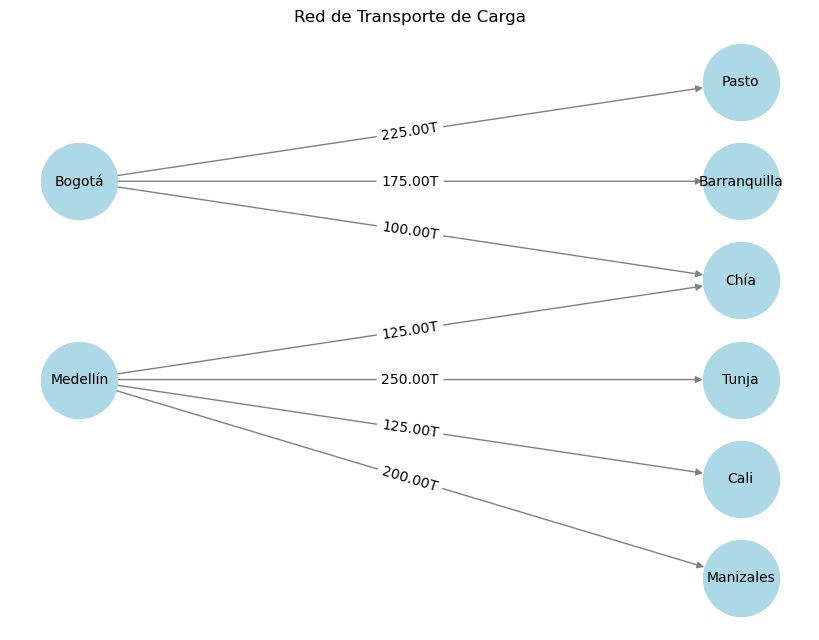

In [50]:
from pyomo.environ import *

# --- Definir el modelo ---
model = ConcreteModel()

# --- Conjuntos ---
model.O = Set(initialize=['Bogotá', 'Medellín'])  # Ciudades origen
model.D = Set(initialize=['Cali', 'Barranquilla', 'Pasto', 'Tunja', 'Chía', 'Manizales'])  # Ciudades destino

# --- Parámetros ---
# Oferta en cada ciudad origen
supply = {'Bogotá': 550, 'Medellín': 700}
model.S = Param(model.O, initialize=supply)

# Demanda en cada ciudad destino
demand = {'Cali': 125, 'Barranquilla': 175, 'Pasto': 225, 'Tunja': 250, 'Chía': 225, 'Manizales': 200}
model.Demand = Param(model.D, initialize=demand)

# Costos de transporte (USD/ton)
costs = {
    ('Bogotá', 'Cali'): 9999999999, ('Bogotá', 'Barranquilla'): 2.5, ('Bogotá', 'Pasto'): 1.6, 
    ('Bogotá', 'Tunja'): 1.4, ('Bogotá', 'Chía'): 0.8, ('Bogotá', 'Manizales'): 1.4,
    ('Medellín', 'Cali'): 2.5, ('Medellín', 'Barranquilla'): 9999999999, ('Medellín', 'Pasto'): 2.0, 
    ('Medellín', 'Tunja'): 1.0, ('Medellín', 'Chía'): 1.0, ('Medellín', 'Manizales'): 0.8
}
model.Cost = Param(model.O, model.D, initialize=costs, default=0)

# --- Variables de decisión ---
model.x = Var(model.O, model.D, within=NonNegativeReals)  # Cantidad de toneladas enviadas

# --- Función Objetivo (Minimizar el costo total de transporte) ---
def obj_rule(model):
    return sum(model.Cost[i, j] * model.x[i, j] for i in model.O for j in model.D)
model.obj = Objective(rule=obj_rule, sense=minimize)

# --- Restricciones ---
# Restricción de oferta
model.SupplyConstraint = ConstraintList()
for i in model.O:
    model.SupplyConstraint.add(sum(model.x[i, j] for j in model.D) <= model.S[i])

# Restricción de demanda
model.DemandConstraint = ConstraintList()
for j in model.D:
    model.DemandConstraint.add(sum(model.x[i, j] for i in model.O) == model.Demand[j])

# --- Resolver el modelo ---
solver = SolverFactory('glpk')
solver.solve(model)

# --- Mostrar resultados ---
print("\nResultados óptimos:")
for i in model.O:
    for j in model.D:
        if model.x[i, j].value > 0:
            print(f"Enviar {model.x[i, j].value:.2f} toneladas de {i} a {j}")

import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx

# Crear el grafo
g = nx.DiGraph()

# Posiciones de los nodos para la visualización
pos = {
    "Bogotá": (0, 1), "Medellín": (0, -1),
    "Pasto": (2, 2), "Barranquilla": (2, 1), "Chía": (2, 0),
    "Tunja": (2, -1), "Cali": (2, -2), "Manizales": (2, -3)
}

# Agregar nodos
g.add_nodes_from(pos.keys())

# Agregar aristas con los valores óptimos obtenidos
edges = []
for i in model.O:
    for j in model.D:
        if model.x[i, j].value > 0:
            edges.append((i, j, model.x[i, j].value))

for o, d, weight in edges:
    g.add_edge(o, d, weight=weight)

# Dibujar el grafo
plt.figure(figsize=(8, 6))
nx.draw(g, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=3000, font_size=10)

# Agregar etiquetas a las aristas
edge_labels = {(o, d): f"{w:.2f}T" for o, d, w in edges}
nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_size=10)

plt.title("Red de Transporte de Carga")
plt.show()



# Problema 3 - Cubrimiento del tablero con damas

## Conjuntos:
- $I = J = \{1,2,3,4,5,6,7,8\}$

## Parámetros:
- La matriz de cobertura $C_{i,j}(k,l)$ es un parámetro clave porque nos dice si una celda $(i,j)$ es cubierta por una dama en la posicion $(k,l)$
- La matriz se representa como:

  $$
  C_{i,j}(k,l) =
  \begin{cases} 
      1, & \text{si la celda } (i,j) \text{ es cubierta por la dama en la posicion} (k,l) \\
      0, & \text{si la celda } (i,j) \text{ no es cubierta por la dama en la posicion}(k,l) 
  \end{cases}
  $$

## Variable de Decisión:
- **Variable binaria** \( X_{i,j} \): Nos indica si hay o no una dama en la posicion

  $$
  X_{i,j} =
  \begin{cases} 
      1, & \text{si se coloca una dama en la posicion } (i,j)  \\
      0, & \text{si no se coloca una dama en la posicion } (i,j) 
  \end{cases}
  $$

## Función Objetivo:
- **Minimizar la cantidad de damas necesarias para cubrir todo el tablero**:

  $$
  \min \left( \sum_{i \in I} \sum_{j \in J} X_{i,j} \right)
  $$

## Restricciones:
1. **Cada celda debe ser cubierta por al menos una dama**:

   $$
   \sum_{(k,l) \in I \times J} C_{(i,j)(k,l)} \cdot X_{i,j} \geq 1, \quad \forall (i,j) \in I \times J
   $$

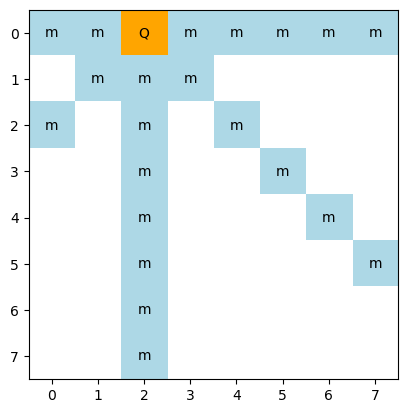

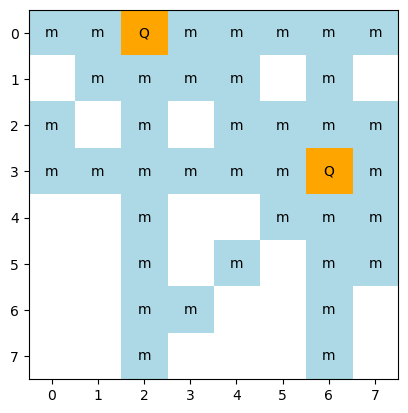

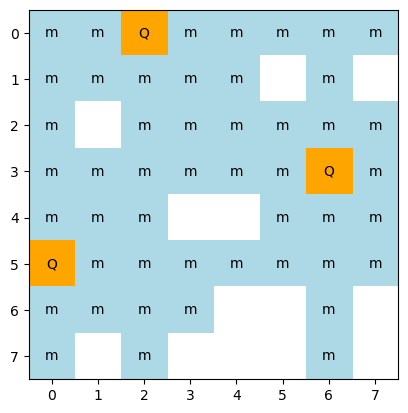

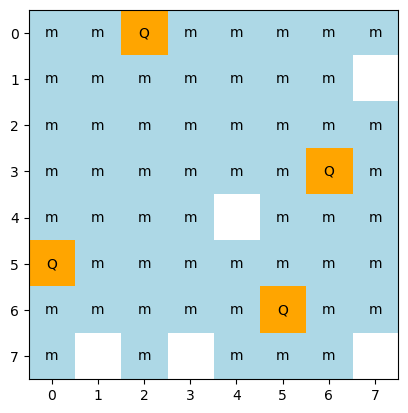

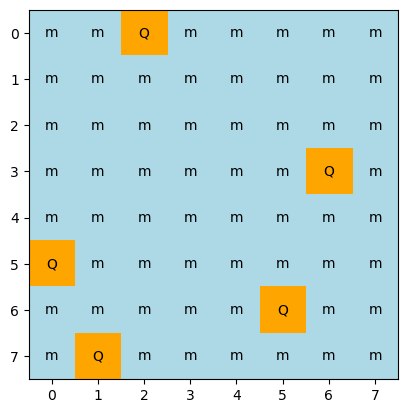

Se necesitan mínimo 5 damas para cubrir todo el tablero.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
from matplotlib.colors import ListedColormap

# Definir el modelo en Pyomo
model = ConcreteModel()

# Conjuntos
model.I = RangeSet(8)  # Filas
model.J = RangeSet(8)  # Columnas

# Variables de decisión
model.x = Var(model.I, model.J, within=Binary)

# Función objetivo (minimizar la cantidad de damas)
model.obj = Objective(expr=sum(model.x[i, j] for i in model.I for j in model.J), sense=minimize)

# Restricciones
def cobertura_rule(model, i, j):
    return sum(model.x[k, l] for k in model.I for l in model.J if (k == i or l == j or abs(k-i) == abs(l-j))) >= 1

model.cobertura = Constraint(model.I, model.J, rule=cobertura_rule)

# Resolver el modelo
solver = SolverFactory('glpk')
solver.solve(model)

def generar_matriz_cobertura(fila, columna, tamaño=8):
    """
    Genera una matriz de cobertura para una dama en una posición dada.
    """
    # Inicializar una matriz vacía de tamaño 8x8
    tablero = np.zeros((tamaño, tamaño), dtype=int)
    
    # Marcar la fila y columna
    tablero[fila, :] = 1  # Horizontal
    tablero[:, columna] = 1  # Vertical
    
    # Marcar las diagonales
    for k in range(-tamaño, tamaño):
        if 0 <= fila + k < tamaño and 0 <= columna + k < tamaño:
            tablero[fila + k, columna + k] = 1
        if 0 <= fila + k < tamaño and 0 <= columna - k < tamaño:
            tablero[fila + k, columna - k] = 1
    
    # Marcar la posición de la dama con un valor especial (2)
    tablero[fila, columna] = 2
    return tablero

def visualizar_matriz(tablero):
    """Visualiza la matriz de cobertura con Matplotlib."""
    # Se define un cmap personalizado:
    # Valor 0 -> "white" (sin cobertura)
    # Valor 1 -> "lightblue" (casilla cubierta)
    # Valor 2 -> "orange" (dama) 
    #cmap = ListedColormap(['white', 'lightblue', 'orange'])
    #plt.imshow(tablero, cmap=cmap, origin='upper')
    for i in range(tablero.shape[0]):
        if 0 not in tablero[i]:
            cmap = ListedColormap(['lightblue', 'orange'])
            plt.imshow(tablero, cmap=cmap, origin='upper')
        else:
            cmap = ListedColormap(['white', 'lightblue', 'orange'])
            plt.imshow(tablero, cmap=cmap, origin='upper')
        for j in range(tablero.shape[1]):
            if tablero[i, j] == 2:
                text = 'Q'
            elif tablero[i, j] == 1:
                text = 'm'
            else:
                text = ''
            plt.text(j, i, text, ha='center', va='center', color='black')
    plt.xticks(range(8))
    plt.yticks(range(8))
    plt.grid(False)
    plt.show()

# Extraer la solución
tablero_solucion = np.zeros((8, 8), dtype=int)
num_damas = 0
for i in model.I:
    for j in model.J:
        if model.x[i, j].value == 1:
            num_damas = num_damas + 1
            tablero_solucion[i-1, j-1] = 2  # Marcar dama en la solución
            tablero_solucion = np.maximum(tablero_solucion, generar_matriz_cobertura(i-1, j-1))
            visualizar_matriz(tablero_solucion)

print(f"Se necesitan mínimo {num_damas} damas para cubrir todo el tablero.")

# Problema 4 - Red de Nodos, Mínimo Costo

## Conjuntos:
- $N$: El conjunto de nodos: $N = \{1,2,3,4,5,6,7\}$

## Parámetros:
- $ C_{i,j} $: Costo del enlace que va del nodo $i$ al nodo $j$.

## Variables de Decisión:
- $X_{i,j}$: Es una variable binaria que indica si el enlace entre el nodo $i$ y el nodo $j$ pertenece a la ruta de costo mínimo:

  $$ X_{i,j} =
  \begin{cases} 
      1, & \text{si el enlace } (i,j) \text{ hace parte de la ruta} \\
      0, & \text{de lo contrario}
  \end{cases}
  $$

## Función Objetivo:
- Minimizar o encontrar el camino de minimo costo para ir desde el nodo 4 hasta el nodo 6:

  $$
  \min \left( \sum_{i \in N} \sum_{j \in N} X_{i,j} \cdot C_{i,j} \right)
  $$

## Restricciones:

1. **Conservación del flujo en nodos intermedios**:  
   - "Todo lo que entra a un nodo intermedio debe salir del nodo intermedio":

   $$
   \sum_{j \in N} X_{i,j} - \sum_{j \in N} X_{j,i} = 0, \quad \forall i \in N | \quad i \neq 4 \wedge i \neq 6
   $$

2. **Desde el nodo de inicio solo puede salir un camino óptimo**:

   $$
   \sum_{j \in N} X_{i,j} = 1, \quad \forall i \in N \quad | i = 4
   $$

3. **Al nodo final solo puede llegar un camino óptimo**:

   $$
   \sum_{i \in N} X_{i,j} = 1, \quad \forall j \in N \quad |  j = 6
   $$


In [6]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Cálculo de la distancia euclidiana entre nodos

# Función para calcular la distancia euclidiana entre dos puntos
def distancia_euclidiana(xi, yi, xj, yj):
    return ((xi - xj)**2 + (yi - yj)**2)**(1/2)

# Coordenadas de los nodos
nodos = {
    1: (20, 6),
    2: (22, 1),
    3: (9, 2),
    4: (3, 25),
    5: (21, 10),
    6: (29, 2),
    7: (14, 12)
}

# Umbral de conexión (Restricción)
umbral = 20

nodos_lista = list(nodos.keys())
num_nodos = len(nodos_lista)
matriz_distancias = np.zeros((num_nodos, num_nodos))

costos ={}

for i in range(num_nodos):
    for j in range(num_nodos):
        if i != j:
            xi, yi = nodos[nodos_lista[i]]
            xj, yj = nodos[nodos_lista[j]]
            distancia = distancia_euclidiana(xi, yi, xj, yj)
            if distancia <= umbral:
                matriz_distancias[i, j] = distancia
                costos[(nodos_lista[i], nodos_lista[j])] = distancia
            else:
                costos[(nodos_lista[i], nodos_lista[j])] = 99999
        else:
            costos[(nodos_lista[i], nodos_lista[j])] = 99999

                
                
print(costos)
                
                
df_distancias = pd.DataFrame(matriz_distancias, index=nodos_lista, columns=nodos_lista)
df_distancias



{(1, 1): 99999, (1, 2): 5.385164807134504, (1, 3): 11.704699910719626, (1, 4): 99999, (1, 5): 4.123105625617661, (1, 6): 9.848857801796104, (1, 7): 8.48528137423857, (2, 1): 5.385164807134504, (2, 2): 99999, (2, 3): 13.038404810405298, (2, 4): 99999, (2, 5): 9.055385138137417, (2, 6): 7.0710678118654755, (2, 7): 13.601470508735444, (3, 1): 11.704699910719626, (3, 2): 13.038404810405298, (3, 3): 99999, (3, 4): 99999, (3, 5): 14.422205101855956, (3, 6): 20.0, (3, 7): 11.180339887498949, (4, 1): 99999, (4, 2): 99999, (4, 3): 99999, (4, 4): 99999, (4, 5): 99999, (4, 6): 99999, (4, 7): 17.029386365926403, (5, 1): 4.123105625617661, (5, 2): 9.055385138137417, (5, 3): 14.422205101855956, (5, 4): 99999, (5, 5): 99999, (5, 6): 11.313708498984761, (5, 7): 7.280109889280518, (6, 1): 9.848857801796104, (6, 2): 7.0710678118654755, (6, 3): 20.0, (6, 4): 99999, (6, 5): 11.313708498984761, (6, 6): 99999, (6, 7): 18.027756377319946, (7, 1): 8.48528137423857, (7, 2): 13.601470508735444, (7, 3): 11.18033

,1,2,3,4,5,6,7
1,0.000000,5.385165,11.704700,0.000000,4.123106,9.848858,8.485281
2,5.385165,0.000000,13.038405,0.000000,9.055385,7.071068,13.601471
3,11.704700,13.038405,0.000000,0.000000,14.422205,20.000000,11.180340
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.029386
5,4.123106,9.055385,14.422205,0.000000,0.000000,11.313708,7.280110
6,9.848858,7.071068,20.000000,0.000000,11.313708,0.000000,18.027756
7,8.485281,13.601471,11.180340,17.029386,7.280110,18.027756,0.000000


Model unknown

  Variables:
    x : Size=49, Index=[1:7]*[1:7]
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (1, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 2) :     0 :   0.0 :     1 : False : False : Binary
        (1, 3) :     0 :   0.0 :     1 : False : False : Binary
        (1, 4) :     0 :   0.0 :     1 : False : False : Binary
        (1, 5) :     0 :   0.0 :     1 : False : False : Binary
        (1, 6) :     0 :   0.0 :     1 : False : False : Binary
        (1, 7) :     0 :   0.0 :     1 : False : False : Binary
        (2, 1) :     0 :   0.0 :     1 : False : False : Binary
        (2, 2) :     0 :   0.0 :     1 : False : False : Binary
        (2, 3) :     0 :   0.0 :     1 : False : False : Binary
        (2, 4) :     0 :   0.0 :     1 : False : False : Binary
        (2, 5) :     0 :   0.0 :     1 : False : False : Binary
        (2, 6) :     0 :   0.0 :     1 : False : False : Binary
        (2, 7) :     0 :   0.0 :     1 : 

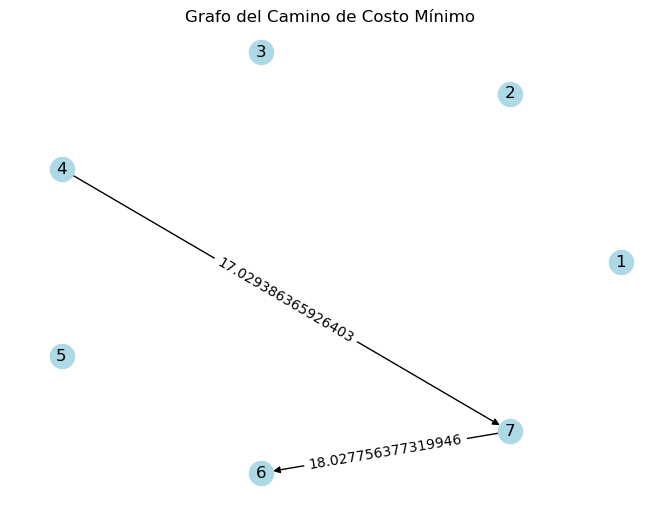

In [ ]:

from __future__ import division
from pyomo.environ import *

from pyomo.opt import SolverFactory

import networkx as nx
import matplotlib.pyplot as plt

Model = ConcreteModel()


numNodes=7

N=RangeSet(1, numNodes)

cost = {
        (1, 1): 99999, (1, 2): 5.385164807134504, (1, 3): 11.704699910719626, (1, 4): 99999, (1, 5): 4.123105625617661, (1, 6): 9.848857801796104, (1, 7): 8.48528137423857, 
        (2, 1): 5.385164807134504, (2, 2): 99999, (2, 3): 13.038404810405298, (2, 4): 99999, (2, 5): 9.055385138137417, (2, 6): 7.0710678118654755, (2, 7): 13.601470508735444, 
        (3, 1): 11.704699910719626, (3, 2): 13.038404810405298, (3, 3): 99999, (3, 4): 99999, (3, 5): 14.422205101855956, (3, 6): 20.0, (3, 7): 11.180339887498949, 
        (4, 1): 99999, (4, 2): 99999, (4, 3): 99999, (4, 4): 99999, (4, 5): 99999, (4, 6): 99999, (4, 7): 17.029386365926403, 
        (5, 1): 4.123105625617661, (5, 2): 9.055385138137417, (5, 3): 14.422205101855956, (5, 4): 99999, (5, 5): 99999, (5, 6): 11.313708498984761, (5, 7): 7.280109889280518, 
        (6, 1): 9.848857801796104, (6, 2): 7.0710678118654755, (6, 3): 20.0, (6, 4): 99999, (6, 5): 11.313708498984761, (6, 6): 99999, (6, 7): 18.027756377319946, 
        (7, 1): 8.48528137423857, (7, 2): 13.601470508735444, (7, 3): 11.180339887498949, (7, 4): 17.029386365926403, (7, 5): 7.280109889280518, (7, 6): 18.027756377319946, (7, 7): 99999
        }

# Variables
Model.x = Var(N,N, domain=Binary)

# funcion Objetivo
Model.obj = Objective(expr = sum(Model.x[i,j]*cost[i,j] for i in N for j in N))

# Restricciones
Model.res1=ConstraintList()
for i in N:
    if i==4:
        Model.res1.add(sum(Model.x[i,j] for j in N)==1)

Model.res2=ConstraintList()
for j in N:
    if j==6:
        Model.res2.add(sum(Model.x[i,j] for i in N)==1)

Model.res3=ConstraintList()
for i in N:
    if i!=4 and i!=6:
        Model.res3.add(sum(Model.x[i,j] for j in N) - sum(Model.x[j,i] for j in N)==0)
    
# solcer
SolverFactory('glpk').solve(Model)

Model.display()


# Construir grafo de los arcos seleccionados
G = nx.DiGraph()
G.add_nodes_from(N)

for i in N:
    for j in N:
        if Model.x[i,j].value == 1 and cost[i,j] < 99999:
            G.add_edge(i, j, weight=cost[i,j])

# Calcular posiciones y dibujar
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', arrows=True)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Grafo del Camino de Costo Mínimo")
plt.show()
